# 実践編: 血液の顕微鏡画像からの細胞検出

ここでは血液細胞の検出タスクに取り組みます。人の血液の顕微鏡画像が与えられたときに、

- 赤血球（Red Blood Cell; RBC）
- 白血球（White Blood Cell; WBC）
- 血小板（Platelet）

の3種の細胞について、それぞれ**何がどの位置にあるか**を個別に認識します。これによって、与えられた画像内にそれらの細胞が何個づつあるか、また、どういう位置にあるか、ということが分かります。

このようなタスクを一般に**物体検出（object detection）**と呼び、画像を入力として、対象の物体（ここでは例えば、上の3種の細胞）ごとに、別々に

1. 四角い矩形（bounding boxと呼ばれる）
2. 「内側にある物体が何か」＝クラスラベル

を出力していくことが目的となります。ただし、**画像中にいくつの物体が含まれるかは事前に分からない**ため、任意個（または十分な数）の物体の**bounding boxとクラスラベルの予測値の組**を出力できるような手法である必要があります。

bounding box（bboxとよく略される）は、`[矩形の左上のy座標, 矩形の左上のx座標, 矩形の右下のy座標, 矩形の右下のx座標]`のような形式で定義されることが多く、クラスは物体の種類ごとに割り振られたIDで表されることが多いようです。例えば、RBCは0、WBCは1、Plateletは2といったように一つの整数が割り当てられます．

![detection_sample.png](https://github.com/mitmul/medical-ai-course-materials/raw/master/notebooks/images/detection_samples.png)
血液の顕微鏡画像からRBC, WBC, Plateletを検出している例



## 環境構築

まず環境構築のためColab上で以下のセルを実行してChainer, CuPy, ChainerCV, matplotlibといったPythonパッケージのインストールを済ませます。

In [1]:
!curl https://colab.chainer.org/install | sh -
!pip install chainercv matplotlib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   8565      0 --:--:-- --:--:-- --:--:--  8565
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 5 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://develop

環境のセットアップが成功したことを以下のセルを実行して確認しましょう。

In [2]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available


## Object Detectionについて

物体検出（object detection）は、Computer Visionの分野で現在も活発に研究が行われているタスクの一つで、自動運転分野やロボティクスなど幅広い領域で重要な役割を果たす技術です。Semantic Segmentationと違い、物体の形（輪郭）までは認識しませんが、**物の種類と位置を、物体ごとに個別に出力**します。

「物の種類」をクラスと呼ぶとき、そのクラスに属する個別の物体をインスタンスと呼ぶことができます。すると，犬が2匹写っている写真があるとき，それは「犬」というクラスに属している犬インスタンスが2個ある，という状態だと言えます．つまり，Semantic Segmentationではインスタンスごとに領域が区別されて出力されるわけではなかった一方で、物体検出の出力はインスタンスごとに別々のbounding boxが出力されるという違いがあります。

ニューラルネットワークを用いた物体検出手法は、[R-CNN](https://arxiv.org/abs/1311.2524)という2014年に発表された手法を皮切りに、様々な改善手法が提案されています。まず一つ、重要なのは[R-CNN](https://arxiv.org/abs/1311.2524), [Fast R-CNN](https://arxiv.org/abs/1504.08083), そして[Faster R-CNN](https://arxiv.org/abs/1506.01497)という、同一の著者らを中心として提案されているConvolutional Neural Networks (CNN)をベースとした物体検出手法の発展の流れです。現在two stageタイプと呼ばれているものはほぼこのFaster R-CNNをベースとしたものとなります。

それに対して，single stageタイプと呼ばれる手法の流れが，[SSD](https://arxiv.org/abs/1512.02325)や[YOLO](https://arxiv.org/abs/1506.02640)，[YOLOv2](https://arxiv.org/abs/1612.08242)，[YOLOv3](https://arxiv.org/abs/1804.02767)などで，特にYOLOとその発展手法は処理のスピードに着目して工夫を行っています．一般的にsingle stageタイプの方がtwo stageタイプよりも処理速度は高速だが，精度が低いと言われています．ただし，最近は高い精度を達成しつつも高速に処理できるように工夫した手法（YOLOv3など）も出てきており，その限りではなくなってきています．

今回は，SSDという手法を用いて，細胞画像のデータセットを使って三種類の細胞の位置と種類を抽出するニューラルネットワークを訓練してみましょう．

## データセットの準備

### データセットダウンロード

今回は[BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset)という血液の顕微鏡画像と、画像それぞれに対してRBC, WBC, Plateletの3つの物体に対するbounding boxのアノテーションが用意された小規模なデータセットを用います。このデータセットはGithubリポジトリで配布されていますので、以下のセルを実行してデータセットをダウンロードしましょう。

In [3]:
!if [ ! -d BCCD_Dataset ]; then git clone https://github.com/Shenggan/BCCD_Dataset.git; fi

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 770, done.
remote: Total 770 (delta 0), reused 0 (delta 0), pack-reused 770
Receiving objects: 100% (770/770), 7.33 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (367/367), done.


データセットは以下のようなファイル構成で配布されています。

```
 BCCD
 |-- Annotations
 |   |
 |   `-- BloodImage_00XYZ.xml (364 items)
 |
 |-- ImageSets
 |   |
 |   `-- Main
 |       |
 |       |-- test.txt
 |       |-- train.txt
 |       |-- trainval.txt
 |       `-- val.txt
 |
 `-- JPEGImages
   |
    `-- BloodImage_00XYZ.jpg (364 items)
 ```

他にもディレクトリがありますが、今回用いるのは上記のファイルだけですので、こちらのみに着目しましょう。

- **Annotationsディレクトリ：**VOC formatと呼ばれる形式で細胞画像それぞれに対して**どの位置に何があるか**という、一般的に画像からの物体検出タスクで必要となるラベルの情報が格納されています。
- **ImageSetsディレクトリ：**学習用データセット・検証用データセット・テスト用データセットのそれぞれに用いる画像のリストが記されたテキストファイルが入っています。これを使ってデータセットの分割を行います。
- **JPEGImagesディレクトリ：**実際に学習や検証・テストに用いる画像データが入っています。

### データセットオブジェクト作成

ChainerCVにはPascal VOCデータセットを簡単に読み込むための便利なクラスが用意されています。これを継承し、`_get_annotations`メソッドをオーバーライドして今回使用するデータセットに合わせて変更を加えます。変更が必要な行は１行だけです。[こちら](https://github.com/chainer/chainercv/blob/v0.10.0/chainercv/datasets/voc/voc_bbox_dataset.py#L90-L115)から該当するコードをコピーしてきて、以下の変更を行い、`BCCDDataset`クラスを定義してみましょう。

```
- label.append(voc_utils.voc_bbox_label_names.index(name))
+ label.append(bccd_labels.index(name))
```

In [0]:
import os
import xml.etree.ElementTree as ET

import numpy as np

from chainercv.datasets import VOCBboxDataset


bccd_labels = ('rbc', 'wbc', 'platelets')


class BCCDDataset(VOCBboxDataset):

    def _get_annotations(self, i):
        id_ = self.ids[i]
        
        # Pascal VOC形式のアノテーションデータは、XML形式で配布されています
        anno = ET.parse(
            os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))

        bbox = []
        label = []
        difficult = []
        for obj in anno.findall('object'):
            bndbox_anno = obj.find('bndbox')
            
            # バウンディングボックスの
            # subtract 1 to make pixel indexes 0-based
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(bccd_labels.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)
        # When `use_difficult==False`, all elements in `difficult` are False.
        difficult = np.array(difficult, dtype=np.bool)
        return bbox, label, difficult

これで、今回用いるデータセットクラスを定義することができました。では、これを用いて学習・検証・テスト用のデータセットオブジェクトを作成してみましょう。

In [5]:
train_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'train')
valid_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'val')
test_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'test')

/usr/local/lib/python3.6/dist-packages/chainercv/datasets/voc/voc_bbox_dataset.py:63: UserWarning: please pick split from 'train', 'trainval', 'val'for 2012 dataset. For 2007 dataset, you can pick 'test' in addition to the above mentioned splits.
  'please pick split from \'train\', \'trainval\', \'val\''


ではデータを可視化して確認してみましょう。trainデータセットから一つデータと対応するラベル情報（bounding boxとクラスの組）を取り出し、ChainerCVが用意している可視化用の便利な関数を使って、画像の上にbounding boxおよび対応するクラスラベルを表示してみます。

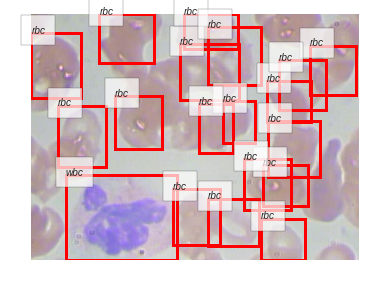

In [6]:
%matplotlib inline
from chainercv.visualizations import vis_bbox

img, bbox, label = train_dataset[0]
ax = vis_bbox(img, bbox, label, label_names=bccd_labels)
ax.set_axis_off()
ax.figure.tight_layout()

## Single Shot Multibox Detector (SSD)

データの準備が完了したので、今回訓練するモデルについて説明を行います。今回は、[Single Shot MultiBox Detector (SSD)](https://arxiv.org/abs/1512.02325)というモデルを使ってみます。

SSDは前述のようにsingle stageタイプと呼ばれる物体検出手法の一種で，まずVGGやResNetのような画像分類で大きな成果をあげたネットワーク構造を用いて画像から特徴マップを抽出します．そのあと，予め特徴マップの空間方向にびっしりと候補領域を仮定しておき（default boxと呼ばれます），そのそれぞれについて「どの程度正解のbounding boxからずれているか」を計算し，これを最小化するように学習を行います．また，この位置の補正と同時にそれぞれが「どのクラスに属しているか」も予測させ，この間違いも少なくするよう学習を行います．

一方，two stageタイプの手法，例えばFaster R-CNNでは，抽出された特徴マップに対してさらに別のネットワークが物体の候補領域（region proposal）を予測し，その結果を使って候補領域ごとの特徴ベクトルを作成し（RoI poolingと呼ばれる計算が用いられます），それらをクラス分類問題と候補領域の修正量を求める回帰問題を解くための2つの異なる小さなネットワークにさらに渡す，という構造をとります．

このため，一般にsingle stageタイプのネットワークの方が高速であると言われます．一方，two stageタイプのものの方が精度は高い，と言われます．このようなトレードオフについては、これを調査した論文（[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)）より、以下の図がしばしば参照されます．
![speed-accuracy-tradeoffs.png](https://github.com/mitmul/medical-ai-course-materials/raw/master/notebooks/images/speed-accuracy-tradeoffs.png)

今回用いるSSDという手法のネットワークアーキテクチャは，以下のような形をしています（SSD論文のFig. 2より引用）．

![ssd-architecture.png](https://github.com/mitmul/medical-ai-course-materials/raw/master/notebooks/images/ssd-architecture.png)

特徴抽出を行うVGG-16ネットワークの途中の出力に対してそれぞれ別々の畳み込み層を適用して検出結果（bounding boxの位置と、その中の物体のクラス）を出力していくことで，複数のスケールでの予測を起こっているのが特徴です．

## モデルの定義

SSDのネットワーク部分の実装は，ChainerCVが提供してくれています．ChainerCVの `chainercv.links.SSD300` というクラスは，縦横が300ピクセルの画像を入力にとるSSDのモデルを表していて，デフォルトで特徴抽出器にはVGG16が用いられます．

学習に必要なロス関数を計算するクラスを用意しましょう．

以下に定義するクラスは，まずSSDモデルのオブジェクトと，ロス計算のためのハイパーパラメータである `alpha` と `k` をコンストラクタで受け取っています．`alpha` は、位置の予測に対する誤差とクラスの予測に対する誤差それぞれの間の重み付けを行う係数です。`k` は hard negative mining のためのパラメータです．学習時，一つの正解bounding boxに対して，モデルは一つの近しい（positiveな）予測と，多くの間違った（negativeな）予測を出力します．この多くの間違った予測をconfidence score（モデルがどの程度確信を持ってその予測を出力しているかを表す値）によってソートした上で，上から positive : negative が 1:k になるように negative サンプルを選択し，ロスの計算に使用します．このバランスを決めているのが `k` というパラメータで、上記論文中では $k = 3$ とされているため、ここでもデフォルトで3を使っています．

`forward` メソッドでは，入力画像と正解の位置・ラベルのリストを受け取って，実際にロスの計算を行っています．物体検出は，物体のlocalization（位置の予測）とclassification（種類（＝クラス）の予測）の二つの問題を同時に解きますが，SSDでは，localization lossとclassification lossを別々に計算します．

In [0]:
import chainer

from chainercv.links.model.ssd import multibox_loss


class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def forward(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss
    

## Data augmentationの実装

深層学習においては大量のデータを用意できるかどうかがモデルの汎化性能に大きな影響を与えます．今回は非常にコンパクトなデータセットを使ってとりあえず学習と結果利用のフローを体験することを目的としているため，実用に耐えうるような十分なバリエーションを持ったデータセットは使っていません．ただし，データを擬似的に増やすように様々な変換を画像とそれに付随するラベルに適用するテクニック（data augmentation）は，大量のデータを集めることができたとしても依然行われることで，ここでどのようにそれを行えばよいか見ておくことに損はないでしょう．

以下に，学習データセット内のデータ点のそれぞれに適用したい変換処理を記述したクラスを定義しておきます．行われる変換は`__call__`メソッド内に記述されている5つとなります．

In [0]:
import copy

import numpy as np

from chainercv import transforms
from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import random_distort
from chainercv.links.model.ssd import resize_with_random_interpolation


class Transform(object):

    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

## 学習の開始

以下では，Chainerが用意するデータセットクラスの一つ，`TransformDataset`を使って，事前に定義したデータ点ごとに適用したい変換を順次用いてくれるようにしています．

基本的な流れはすでに学んだ画像分類やセグメンテーションなどを行うネットワークの訓練の仕方と多くが共通しています．

まずは必要なモジュール類をインポートしておきます．ここではChainerCVが提供しているSSD300を学習するニューラルネットワークに採用し，その実装を利用することにします．

In [0]:
from chainer.datasets import TransformDataset
from chainer.optimizer_hooks import WeightDecay
from chainer import serializers
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainercv.links import SSD300
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links.model.ssd import GradientScaling

chainer.cuda.set_max_workspace_size(1024 * 1024 * 1024)
chainer.config.autotune = True

次に，以下の設定項目をあとから変更が容易なように，ここで変数に代入しておきます．

- バッチサイズ
- 使用するGPUのID
- 結果の出力ディレクトリ名
- 学習率の初期値
- 学習を行うエポック数

In [0]:
batchsize = 32
gpu_id = 0
out = 'results'
initial_lr = 0.001
training_epoch = 300

まずは，モデルオブジェクトを作成します．ベースとなるモデルの実装はChainerCVが提供しているSSD300（入力画像サイズが300 x 300のSSDアーキテクチャ）を使用します．重みの初期値として，特徴抽出に用いる部分のネットワークをImageNetデータセットを用いてpre-trainingしたものを使用するよう，`pretrained_model`というオプションに`'imagenet'`という文字列を渡しています．最後に，SSDのロス関数計算は少し特殊ですが，必要な後処理などを隠蔽してくれる`MultiboxTrainChain`というクラスでモデルをラップし，`train_chain`というオブジェクトを作成しています．これを学習中はパラメータ更新対象のChainとします．

In [11]:
model = SSD300(n_fg_class=len(bccd_labels), pretrained_model='imagenet')
train_chain = MultiboxTrainChain(model)

From: https://chainercv-models.preferred.jp/ssd_vgg16_imagenet_converted_2017_06_09.npz
To: /root/.chainer/dataset/_dl_cache/b4130ae0aa259c095b50ff95d81c32ee
  %   Total    Recv       Speed  Time left
100   76MiB   76MiB   4042KiB/s    0:00:00

上のセルを実行すると，自動的にImageNetでVGG16というネットワークを訓練した際の重みがダウンロードされると思います．このように，ChainerCVではいくつかのpre-trained modelを非常に簡単に使い始めることができるような形で提供しています．

次に，データセットクラスやイテレータを作成しましょう．こちらはすでに学んだ画像分類の場合などと同様です．データセットから取り出されるデータ点は，それぞれ事前に定義しておいた`Transform`クラスで定義した変換処理にて変換されます．

In [0]:
transformed_train_dataset = TransformDataset(train_dataset, Transform(model.coder, model.insize, model.mean))

train_iter = chainer.iterators.MultiprocessIterator(transformed_train_dataset, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batchsize, repeat=False, shuffle=False)

次にOptimizerを作成します．今回はMomentum SGDという手法を用いてモデルのパラメータの最適化を行います．その際に，モデルの中にある線形変換が持つバイアスのパラメータに対しては勾配が2倍の大きさになるように`update_rule`に対してフックを設定します．また，バイアスパラメータの場合にはweight decayは行わず，バイアスパラメータ以外のパラメータに対してはweight decayを行うように設定しています．

In [0]:
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(train_chain)
for param in train_chain.params():
    if param.name == 'b':
        param.update_rule.add_hook(GradientScaling(2))
    else:
        param.update_rule.add_hook(WeightDecay(0.0005))

次にUpdaterのオブジェクトを作成します．今回はUpdaterに最もシンプルな`StandardUpdater`を用いました．CPUもしくはシングルGPUを用いて学習を行う際には，このUpdaterを使います．

In [0]:
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

最後に，Trainerオブジェクトを作成します．Trainerの初期化時には，コンストラクタの第１引数に上で作成した`StandardUpdater`オブジェクトの`updater`を渡します．第２引数には，いつ学習を終了するのかを表すTriggerを渡します．これは，

In [14]:
trainer = training.Trainer(updater, (training_epoch, 'epoch'), out)
trainer.extend(
    extensions.ExponentialShift('lr', 0.1, init=initial_lr),
    trigger=triggers.ManualScheduleTrigger([200, 250], 'epoch'))

trainer.extend(
    DetectionVOCEvaluator(
        valid_iter, model, use_07_metric=False,
        label_names=bccd_labels),
    trigger=(1, 'epoch'))

log_interval = 10, 'epoch'
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'lr',
     'main/loss', 'main/loss/loc', 'main/loss/conf',
     'validation/main/map', 'elapsed_time']),
    trigger=log_interval)
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(
            ['main/loss', 'main/loss/loc', 'main/loss/conf'],
            'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['validation/main/map'],
            'epoch', file_name='accuracy.png'))
trainer.extend(extensions.snapshot(
    filename='snapshot_epoch_{.updater.epoch}'), trigger=(10, 'epoch'))

trainer.run()

epoch       iteration   lr          main/loss   main/loss/loc  main/loss/conf  validation/main/map  elapsed_time
10          65          0.001       6.75134     2.08291        4.66843         0.118168             230.543       
20          129         0.001       4.12112     1.58375        2.53737         0.181493             435.038       
30          193         0.001       3.59885     1.31919        2.27966         0.279919             635.634       
40          257         0.001       3.1998      1.07375        2.12605         0.573733             835.256       
50          321         0.001       2.94131     0.926096       2.01522         0.657611             1034.6        
60          385         0.001       2.86323     0.887698       1.97553         0.670849             1233.12       
70          449         0.001       2.73648     0.819021       1.91746         0.696257             1428.25       
80          513         0.001       2.63796     0.765831       1.87212         0.6

パラメータを変更して再度学習を回す場合は，モデルのオブジェクトを定義したセルから順に実行し直してみてください．

## 学習結果を用いた推論

学習を行った結果得られるモデルのパラメータは，`extensions.snapshot()`というTrainer extensionによってファイルに保存されています．保存先は，デフォルトではTrainerオブジェクト初期化時に渡した`out`という引数によって指定されたディレクトリ以下となります．今回は，`results`以下にあるはずです．

In [18]:
!ls -la results/

total 5262416
drwxr-xr-x 2 root root      4096 Nov 12 04:56 .
drwxr-xr-x 1 root root      4096 Nov 12 03:14 ..
-rw-r--r-- 1 root root     16459 Nov 12 04:56 accuracy.png
-rw-r--r-- 1 root root     14212 Nov 12 04:56 log
-rw-r--r-- 1 root root     19224 Nov 12 04:56 loss.png
-rw-r--r-- 1 root root 179359510 Nov 12 03:19 snapshot_epoch_10
-rw-r--r-- 1 root root 179635488 Nov 12 03:48 snapshot_epoch_100
-rw-r--r-- 1 root root 179658565 Nov 12 03:52 snapshot_epoch_110
-rw-r--r-- 1 root root 179626119 Nov 12 03:55 snapshot_epoch_120
-rw-r--r-- 1 root root 179621515 Nov 12 03:58 snapshot_epoch_130
-rw-r--r-- 1 root root 179599718 Nov 12 04:02 snapshot_epoch_140
-rw-r--r-- 1 root root 179622100 Nov 12 04:05 snapshot_epoch_150
-rw-r--r-- 1 root root 179636744 Nov 12 04:08 snapshot_epoch_160
-rw-r--r-- 1 root root 179623075 Nov 12 04:12 snapshot_epoch_170
-rw-r--r-- 1 root root 179632764 Nov 12 04:15 snapshot_epoch_180
-rw-r--r-- 1 root root 179642466 Nov 12 04:18 snapshot_epoch_190
-rw-r--r-- 

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp -r results /content/gdrive/My\ Drive/Colab-results/

以上のようなシェルコマンドを実行してみると，いくつか`.npz`という拡張子で終わるファイルが見つかりました．これらはそれぞれ，学習中にTrainerの中にあった学習を再開するために必要なパラメータをまとまて保存したものです．今回は推論に必要なモデルのパラメータだけを取り出して使います．

モデルのパラメータを取り出す方法としては，`chainer.serializers.load_npz`を用いて`.npz`ファイルをモデルオブジェクトにロードする際に，`.npz`ファイルのキーに対してある階層以下のものだけ見るように指定する方法があります．Trainerオブジェクト全体のスナップショットをとった場合には，Optimizerが持つiteration回数の情報など，モデル内部のパラメータ以外のものも格納されていますが，`updater/model:main/model`というprefixを渡せば，モデルのパラメータ部分のみを取り出すことだできます．

では，学習に用いたのとは別の場所で，このスナップショットとモデルの定義のコードだけが渡された状況を想定して，新しいモデルオブジェクトを作成し，そこに学習済みパラメータをロードしてみましょう．


In [0]:
# Create a model object
model = SSD300(n_fg_class=len(bccd_labels), pretrained_model='imagenet')

# Load parameters to the model
chainer.serializers.load_npz(
    'results/snapshot_epoch_300', model, path='updater/model:main/model/')

では，学習済みの重みをロードしたモデルを使って，テスト画像の一つに対して細胞の検出処理を行ってみます．以下のコードでは，画像の読み込み，推論の実行，そして結果の可視化までをChainerCVを用いて順に行っています．

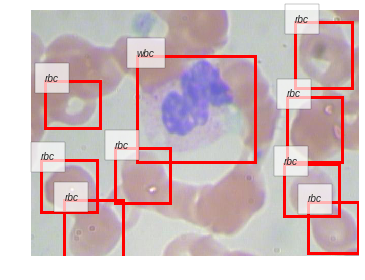

In [17]:
from chainercv import utils

# Load a test image
img = utils.read_image('BCCD_Dataset/BCCD/JPEGImages/BloodImage_00007.jpg', color=True)

# Perform inference
bboxes, labels, scores = model.predict([img])

# Extract the results
bbox, label, score = bboxes[0], labels[0], scores[0]

# Visualize the detection results
ax = vis_bbox(img, bbox, label, label_names=bccd_labels)
ax.set_axis_off()
ax.figure.tight_layout()